## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [4]:
data = pd.read_csv('C:\IDE\EDA_5_ A_B_тестирование\data\\ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [6]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [13]:
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data


,date,group,users_count,purchase
0,2021-01-02,A,2894,362
1,2021-01-02,B,2889,348
2,2021-01-03,A,6684,760
3,2021-01-03,B,6710,762
4,2021-01-04,A,6655,810
5,2021-01-04,B,6629,773
6,2021-01-05,A,6538,801
7,2021-01-05,B,6586,758
8,2021-01-06,A,6684,778
9,2021-01-06,B,6844,848


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [18]:
a_cnt = daily_data['users_count'][daily_data['group'] == 'A'].sum()
print('Количество посещений группы A:',a_cnt)

b_cnt = daily_data['users_count'][daily_data['group'] == 'B'].sum()
print('Количество посещений группы B:',b_cnt)

a_buy = data['purchase'][data['group'] == 'A'][data['purchase'] == 1].sum()
print('Количество покупок группы A:',a_buy)

b_buy = data['purchase'][data['group'] == 'B'][data['purchase'] == 1].sum()
print('Количество покупок группы B:',b_buy)

a_buy_sum = data['price'][data['group'] == 'A'].sum()/10**6
print('Сумма покупок группы A:',a_buy_sum)

b_buy_sum = data['price'][data['group'] == 'B'].sum()/10**6
print('Сумма покупок группы A:',b_buy_sum)



Количество посещений группы A: 147202
Количество посещений группы B: 147276
Количество покупок группы A: 17723
Количество покупок группы B: 17514
Сумма покупок группы A: 1436.26
Сумма покупок группы A: 1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [21]:
a_set = set(data['user_id'][data['group'] == 'A'])
b_set = set(data['user_id'][data['group'] == 'B'])
user_intersection = a_set.intersection(b_set)
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [25]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

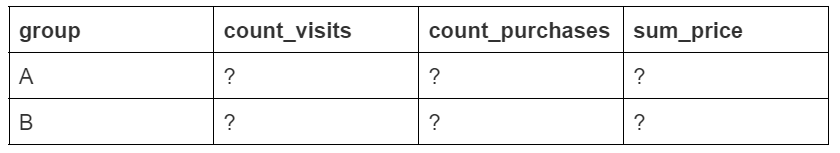
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [36]:
updated_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','price': 'count_price','purchase': 'count_purchases'})
updated_data.head()

,group,count_visits,count_purchases,count_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

В целом хоть и различия есть, но по сравнению с общим количеством людей в выборке, мы можем опустить этот момент

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [59]:
updated_data['conversion'] = round(updated_data['count_purchases']/updated_data['count_visits'] *100,2)
print('Конверсия группы A',updated_data['conversion'][updated_data['group'] == 'A'])
print('Конверсия группы B',updated_data['conversion'][updated_data['group'] == 'B'])

updated_data['mean_check'] = round(updated_data['count_price']/updated_data['count_purchases'])
print('Средний чек группы A',updated_data['mean_check'][updated_data['group'] == 'A'])
print('Средний чек группы B',updated_data['mean_check'][updated_data['group'] == 'B'])

Конверсия группы A 0    12.03
Name: conversion, dtype: float64
Конверсия группы B 1    11.89
Name: conversion, dtype: float64
Средний чек группы A 0    81076.0
Name: mean_check, dtype: float64
Средний чек группы B 1    88665.0
Name: mean_check, dtype: float64


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия группы А больше чем у группы В, но средний чек больше у группы В, соответственно какой из показателей более важен, тот вариант и будет приоритетней 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [70]:
df = data[data['user_id'].apply(lambda x: x not in user_intersection)]
df['Thailand'] = df['price'][df['price'] == 100000 ]
df['Turkey'] = df['price'][df['price'] == 60000 ]
df['Maldives'] = df['price'][df['price'] == 200000 ]
df['SPB'] = df['price'][df['price'] == 10000 ]
df['Kamchatcka'] = df['price'][df['price'] == 150000 ]
piv = pd.pivot_table(df,
                     index=['group'],
                     values=['Thailand','Turkey','Maldives','SPB','Kamchatcka'],
                     aggfunc={"Thailand": 'count','Turkey': 'count','Maldives': 'count','SPB': 'count','Kamchatcka': 'count',}
    
)
piv

C:\Users\nikol\AppData\Local\Temp\ipykernel_15428\1000236161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Thailand'] = df['price'][df['price'] == 100000 ]
C:\Users\nikol\AppData\Local\Temp\ipykernel_15428\1000236161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Turkey'] = df['price'][df['price'] == 60000 ]
C:\Users\nikol\AppData\Local\Temp\ipykernel_15428\1000236161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,Kamchatcka,Maldives,SPB,Thailand,Turkey
group,,,,,
A,3478,1724,5182,1832,5271
B,3438,1694,5201,5227,1730


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot: ylabel='group'>

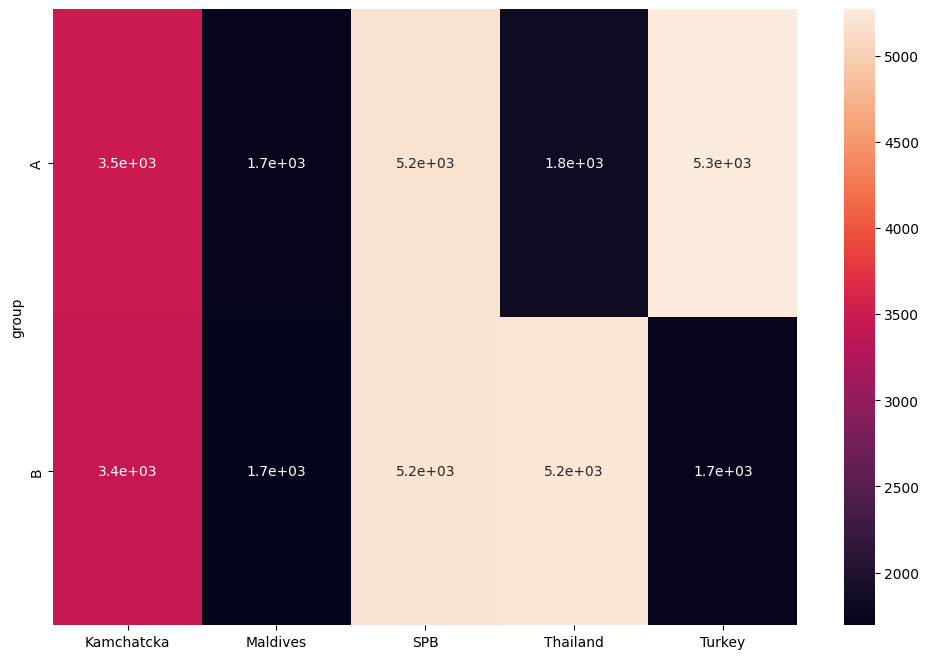

In [72]:
plt.figure(figsize = (12,8))
sns.heatmap(piv,annot=True)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Обе группы очень часто берут туры на камчатку, исходя из того, что люди из Москвы часто летают туда в командировки.
На Мальдивы обе группы летают реже, так как это достаточно люксовый тип отдыха, не каждому по карману.
В Санкт-Петербург люди летают довольно часто из обеих групп, исходя из того, что это могут быть рабочие поездки, а также отдых, билеты достаточно дешёвые, многим по карману.
Далее видим чёткое различие с Тайландом и Турцией. Группа А предпочитает отдых в Турции, а группа В отдых в Тайланде, по нескольким присинам может быть такой исход. Например нецелесообразная выборка, горячие путёвки в какую-либо из стран в этот промежуток времени 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [73]:
data_2 = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [76]:
daily_data = data_2.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count','purchase':'count_purchases','price':'sum_price'})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['users_count']*100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']
print(round(daily_data['conversion'][daily_data['date']=='2021-01-03'],2))
print(round(daily_data['mean_check'][daily_data['date']=='2021-01-03'])) 

2    11.34
3    11.39
Name: conversion, dtype: float64
2    82888.0
3    87480.0
Name: mean_check, dtype: float64


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [80]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_users_count'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases']

print('Кумулятивная конверсия на 20 января', round(daily_data['cum_conversion'][daily_data['group'] == 'B'][daily_data['date'] == '2021-01-20'],2))
print('Кумулятивный средний чек на 12 января',round(daily_data['cum_mean_check'][daily_data['group'] == 'A'][daily_data['date'] == '2021-01-12']))


Кумулятивная конверсия на 20 января 37    11.9
Name: cum_conversion, dtype: float64
Кумулятивный средний чек на 12 января 20    81492.0
Name: cum_mean_check, dtype: float64


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

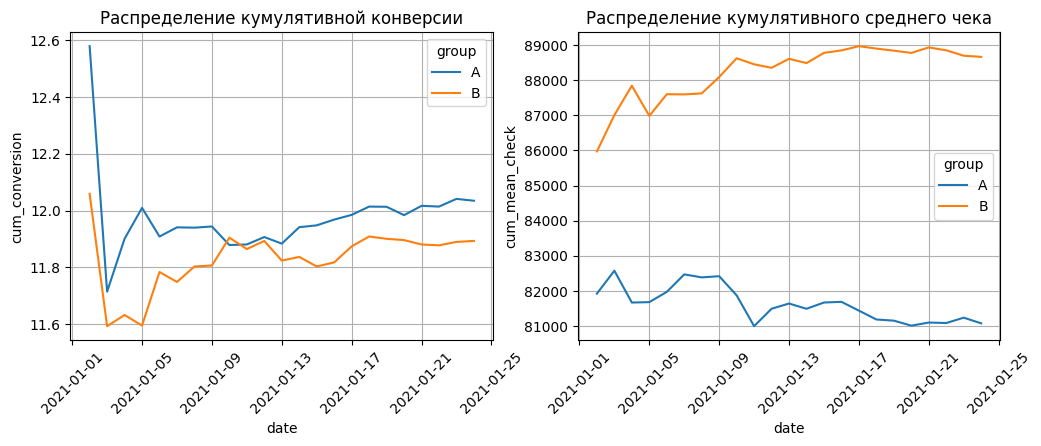

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x='date', y = "cum_conversion", data= daily_data, hue='group', ax=axes[0])
sns.lineplot(x='date', y = "cum_mean_check", data= daily_data, hue='group',ax=axes[1])

axes[0].set_title('Распределение кумулятивной конверсии');
axes[1].set_title('Распределение кумулятивного среднего чека');

axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)

axes[0].grid(True);
axes[1].grid(True);

A/B тест стабилизорован по значению метрик во времени и уже можно делать какие-либо выводы. Кумулятивный средний чек больше у группы B, однако кумулятивная конверсия больше у группы A, таким оюразом, мы можем сказать, что какая из метрик является более приоритетной, тому варианту дизайна и отдадим предпочтение

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [85]:
converted_piv= df.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Мы получили p-value = 0.12, а значит мы не можем отвергнуть нулевую гипотезу, истинные значения конверсий в группах равны, то полученная разница в метрике в группах статистически не значима.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [89]:
#фильтруем данные группы А
a_data = df[df['group'] == 'A']
#фильтруем данные группы B
b_data = df[df['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [91]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, так как интервал охватывает точку 0

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [92]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data['mean_check'][daily_data['group'] == 'A'])
shapiro_result_b = shapiro(daily_data['mean_check'][daily_data['group'] == 'B'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [93]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data['mean_check'][daily_data['group'] == 'A'],
    b=daily_data['mean_check'][daily_data['group'] == 'B'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Так как p-value = 0, то мы должны отвергнуть нулевую гипотезу и можем сделать вывод, что статистическая разница определённо есть

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [97]:
a_data = daily_data[daily_data.group == 'A']
b_data = daily_data[daily_data.group == 'B']

def conf_interval(n, x_mean, x_std, gamma=0.95):
  '''Функция для расчета границ доверительного интервала, где
          n - размер выборки, 
          x_mean - выборочная средняя, 
          x_std - стандартное отклонение выборки, 
          gamma - уровень доверия'''
  alpha = 1 - gamma 
  k = n - 1 
  t_crit = -t.ppf(alpha/2, k) 
  eps = t_crit * x_std/(n ** 0.5) 
  lower_bound = x_mean - eps 
  upper_bound = x_mean + eps 
  return round(lower_bound, 2), round(upper_bound, 2)


# Доверительный интервал для группы A 
n = a_data['mean_check'].count() 
x_mean = a_data['mean_check'].mean() 
x_std = a_data['mean_check'].std() 
print('Доверительный интервал для истинного среднего чека группы А:', conf_interval(n, x_mean, x_std))  # 79630, 82308
print()


# Доверительный интервал для группы B
n = b_data['mean_check'].count() 
x_mean = b_data['mean_check'].mean() 
x_std = b_data['mean_check'].std() 
print('Доверительный интервал для истинного среднего чека группы B:', conf_interval(n, x_mean, x_std))

Доверительный интервал для истинного среднего чека группы А: (79630.35, 82308.22)

Доверительный интервал для истинного среднего чека группы B: (87625.83, 89525.61)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Так как перечесений нет, соответсвенно истинное среднее точно отличается и мы можем сделать вывод, что средний чек группы B  определённо больше.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Из проведённого A/B теста мы можем понять, что исходя из метрики конверсии, мы можем не менять дизайн сайта, дабы исключить лишние расходы.
Исходя из метрики среднего чека мы ясно видим, что дизайн сайта сменить нужно, так как средний чек увеличивается.
Общий вывод: стоит сменить дизайн сайта, так как пусть и конверсия равна, средний чек всё же больше во втором случае.